In [ ]:
# load in all t_vals (mean from cross val?)
# plot with channels with lowest p-val, 

In [6]:
import pandas as pd
import numpy as np
import os
import itertools
import pickle
import sys
import scipy.stats 
from statsmodels.stats.api import multipletests


def bootstrap_ci(x,alpha=0.05,bootnum=10000,avgfun=np.mean):
    """compute confidence intervals around the mean/median using bootstrapping
    in:
    -x: ndarray, repetitions across first dimension
    -alpha: float. alpha level (1-alpha) confidence interval
    -bootnum: int. number of bootstraps (10000 default)
    -avgfun: callable (e.g. np.mean or np.median). requires 'axis' keyword
    
    out:
    -left,right: lower and upper bounds
    """

    bootfunc=lambda x: avgfun(x,axis=0)
    x_bootmean=bootstrap(x,bootfunc=bootfunc,bootnum=bootnum)
    left=np.percentile(x_bootmean,alpha/2*100,axis=0)
    right=np.percentile(x_bootmean,100-alpha/2*100,axis=0)
    return(left,right)

def bootstrap_se(x,bootnum=10000,avgfun=np.mean):
    """compute confidence standard error of the mean/median using bootstrapping
    in:
    -x: ndarray, repetitions across first dimension
    -alpha: float. alpha level (1-alpha) confidence interval
    -bootnum: int. number of bootstraps (10000 default)
    -avgfun: callable (e.g. np.mean or np.median). requires 'axis' keyword
    
    out:
    -left,right: lower and upper bounds
    """
    bootfunc=lambda x: avgfun(x,axis=0)
    x_bootmean=bootstrap(x,bootfunc=bootfunc,bootnum=bootnum)
    se=np.std(x_bootmean,axis=0)
    return(se)

def bootstrap_BET(samps_in,pop_mean=0,tail='2s',n_boots=10e4):
    """one-sample (paired) bootstrap t-test; Bootstrap Equivalence test
                    
    in:
    - samps: nd.array, shape(n_samples)
        datapoints 
    - pop_mean: float, Default=0
        mean to test against
    - tail: str, default: '2s'
        options: '2s','l','r' (for two-tailed,left or right-tailed)
    - n_boots: int; default=10e3
        number of bootstraps (determines precision)
    
    out:
    -pval: float 
        fraction of instances where simulated null distribution returns
        test statistic that is at least as extreme as emprical test stat.
        
    dependencies: bootstrap from astropy
    """
    seed = np.random.randint(1000)
    # test stat 
    t_func=lambda x,dim:(x.mean(dim)-pop_mean)/(x.std(dim)/np.sqrt(x.shape[dim]))
    # make null distribution 
    null_boot_test=t_func(bootstrap(samps_in-samps_in.mean(0)+pop_mean,bootnum=int(n_boots), 
                                    seed=seed),1)
    emp_test=t_func(samps_in,0)
    
    # make alt distribution
    alt_distr=bootstrap(samps_in,bootnum=int(n_boots), 
                        seed=seed)
    alpha_distr=alt_distr.mean()-null_boot_test

    # if distribution = 0
    if (alpha_distr>0).sum() == 0:
        omega = 1
    else:
        omega= (alpha_distr<=0).sum() / (alpha_distr>0).sum()

    # get mu, sigma and sample size
    mu = alpha_distr.mean()
    sigma = alpha_distr.std()
    n = len(samps_in)

    # calculate evidence strength
    evidence_strength = np.log( ((1-omega) * mu + (omega*sigma))   /   ((1 + omega * np.log(n)) * sigma))
    return(evidence_strength)

def bootstrap_t_onesample(samps_in,pop_mean=0,tail='2s',n_boots=10e4,seed=123):
    """one-sample (paired) bootstrap t-test; returns p-value only
                    
    in:
    - samps: nd.array, shape(n_samples)
        datapoints 
    - pop_mean: float, Default=0
        mean to test against
    - tail: str, default: '2s'
        options: '2s','l','r' (for two-tailed,left or right-tailed)
    - n_boots: int; default=10e3
        number of bootstraps (determines precision)
    
    out:
    -pval: float 
        fraction of instances where simulated null distribution returns
        test statistic that is at least as extreme as emprical test stat.
    see also:
    - fmt_boot_pval, function to format the pvalues, changes p=0 into P < (1/n_boots) statement 
    dependencies: bootstrap from astropy
    """
    t_func=lambda x:(x.mean(0)-pop_mean)/(x.std()/np.sqrt(x.shape[0]))

    # test stat 
    t_func=lambda x,dim:(x.mean(dim)-pop_mean)/(x.std(dim)/np.sqrt(x.shape[dim]))
    # make null distribution 
    null_boot_test=t_func(bootstrap(samps_in-samps_in.mean(0)+pop_mean,bootnum=int(n_boots),seed=seed),1)
    emp_test=t_func(samps_in,0)
    # return p-value as probability of obtaining a test stat at least as extreme under the null 
    if tail in ['2s','two','both']:
        left_pval=np.mean(null_boot_test<emp_test)
        right_pval=np.mean(null_boot_test>emp_test)
        return(2*min(left_pval,right_pval))
    elif tail.lower() in ['l','left']:
        return(np.mean(null_boot_test<emp_test))
    elif tail.lower() in ['r','right']:
        return(np.mean(null_boot_test>emp_test))
    else:
        raise ValueError('tail not recognised!')
        
flatten= lambda l: np.array([item for sublist in l for item in sublist])


def bootstrap(data, bootnum=1000, samples=None, bootfunc=None, seed=False):
    """Performs bootstrap resampling on numpy arrays. (FUNCTION FROM ASTROPY)

    Bootstrap resampling is used to understand confidence intervals of sample
    estimates. This function returns versions of the dataset resampled with
    replacement ("case bootstrapping"). These can all be run through a function
    or statistic to produce a distribution of values which can then be used to
    find the confidence intervals.

    Parameters
    ----------
    data : numpy.ndarray
        N-D array. The bootstrap resampling will be performed on the first
        index, so the first index should access the relevant information
        to be bootstrapped.
    bootnum : int, optional
        Number of bootstrap resamples
    samples : int, optional
        Number of samples in each resample. The default `None` sets samples to
        the number of datapoints
    bootfunc : function, optional
        Function to reduce the resampled data. Each bootstrap resample will
        be put through this function and the results returned. If `None`, the
        bootstrapped data will be returned

    Returns
    -------
    boot : numpy.ndarray

        If bootfunc is None, then each row is a bootstrap resample of the data.
        If bootfunc is specified, then the columns will correspond to the
        outputs of bootfunc.

    """
    if seed != False:
        np.random.seed(seed)
    
    if samples is None:
        samples = data.shape[0]

    # make sure the input is sane
    if samples < 1 or bootnum < 1:
        raise ValueError("neither 'samples' nor 'bootnum' can be less than 1.")

    if bootfunc is None:
        resultdims = (bootnum,) + (samples,) + data.shape[1:]
    else:
        # test number of outputs from bootfunc, avoid single outputs which are
        # array-like
        try:
            resultdims = (bootnum, len(bootfunc(data)))
        except TypeError:
            resultdims = (bootnum,)

    # create empty boot array
    boot = np.empty(resultdims)

    for i in range(bootnum):
        bootarr = np.random.randint(low=0, high=data.shape[0], size=samples)
        
#         if seed != False: print(bootarr)
        if bootfunc is None:
            boot[i] = data[bootarr]
        else:
            boot[i] = bootfunc(data[bootarr])

    return boot

In [7]:
def bootstrap_resample(data, bootnum=100, samples=None, seed=3333, ppdict=False):
    """Performs bootstrap resampling on numpy arrays.

    Bootstrap resampling is used to understand confidence intervals of sample
    estimates. This function returns versions of the dataset resampled with
    replacement ("case bootstrapping"). These can all be run through a function
    or statistic to produce a distribution of values which can then be used to
    find the confidence intervals.

    Parameters
    ----------
    data : numpy.ndarray
        N-D array. The bootstrap resampling will be performed on the first
        index, so the first index should access the relevant information
        to be bootstrapped.
    bootnum : int, optional
        Number of bootstrap resamples
    samples : int, optional
        Number of samples in each resample. The default `None` sets samples to
        the number of datapoints

    Returns
    -------
    boot : numpy.ndarray

    """
    np.random.seed(seed)
    
    if samples is None:
        samples = data.shape[0]

    resultdims = (bootnum,) + (samples,) + data.shape[1:]

    # create empty boot array
    boot = np.empty(resultdims)
    ppindx = np.empty(resultdims, dtype=object)
    
    for i in range(bootnum):
        bootarr = np.random.randint(low=0, high=data.shape[0], size=samples)
        boot[i] = data[bootarr]

        if ppdict != False: 
            #print(ppdict, bootarr)
            ppindx[i] = [ppdict[i] for i in bootarr]
        
    if not ppdict: return(boot)
    else: return(boot,ppindx)

def bootstrap_dict_items(score_dict, bootnum, samples=None, ppdict=False):
    
    if samples == 'match_min': samples=len(score_dict[min(score_dict, key=lambda k: len(score_dict[k]))])
    
    scores_boot = {}
    ppindx_boot = {}
    for i in score_dict.keys():
        if not ppdict: scores_boot[i] = bootstrap_resample(np.array(score_dict[i]), bootnum, samples=samples, ppdict=ppdict)
        else: scores_boot[i], ppindx_boot[i] = bootstrap_resample(np.array(score_dict[i]), bootnum, samples=samples, ppdict=ppdict[i])
        
    if not ppdict: return(scores_boot)
    else: return(scores_boot, ppindx_boot)

In [109]:
import numpy as np

# Set the random seed for reproducibility
np.random.seed(0)

# Parameters for dummy data generation
num_participants = 15
num_timepoints = 30

# Generate dummy data
# Each participant will have a linear trend over timepoints with added noise
timepoints = np.arange(num_timepoints)
data = np.array([0.3 * timepoints + np.random.normal(0, 2, num_timepoints) for _ in range(num_participants)])

data.shape


(15, 30)

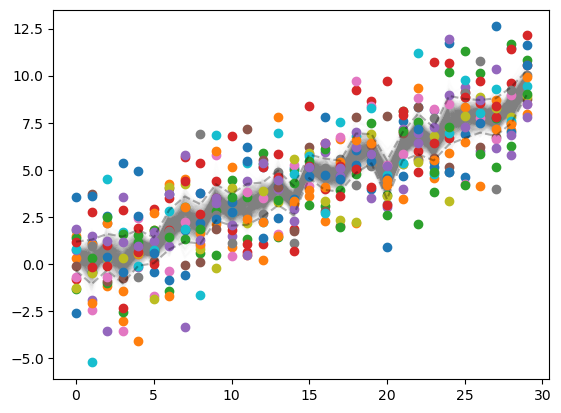

In [110]:
import matplotlib.pyplot as plt

abc = bootstrap_resample(data, bootnum=1000)
plt.plot(np.mean(abc, axis=1).T, alpha=0.01, color='grey')
plt.plot(data.T,marker='o', linestyle='None')

# calculate conf interval
cil, cir = bootstrap_ci(data)
plt.plot(cil, color='black', alpha=0.3, ls='--')
plt.plot(cir, color='black', alpha=0.3, ls='--')

In [87]:
# itterate over timestamps
for d in data.T:
    print(bootstrap_BET(d))

-1.2218954478092
-1.1735414916582774
-1.0090273416060795
0.34976608052685193
0.28678942260480234
0.6832976604346173
0.8114445511032593
0.6453374241492117


In [111]:
p_vals = np.array([bootstrap_t_onesample(d, pop_mean=0, n_boots=100000) for d in data.T])

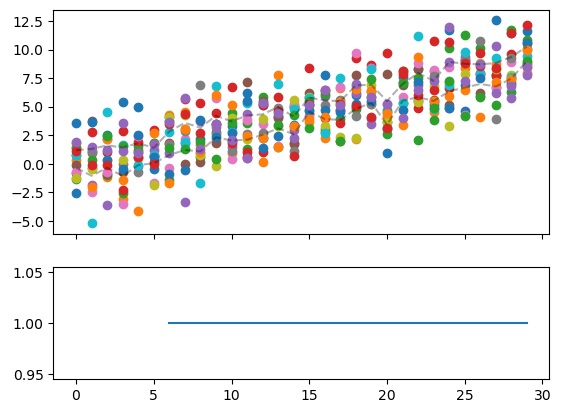

In [112]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,  gridspec_kw={'height_ratios': [2, 1]},  sharex=True)

axs[0].plot(data.T,marker='o', linestyle='None')

# calculate conf interval
cil, cir = bootstrap_ci(data)
axs[0].plot(cil, color='black', alpha=0.3, ls='--')
axs[0].plot(cir, color='black', alpha=0.3, ls='--')


## GET SIG

# Add dotted line for p-values < 0.4
below_threshold = p_vals < 0.05
x_positions = np.where(below_threshold)[0]

# get sig parths
all_below = np.zeros(len(p_vals))
all_below[:] = np.nan
all_below[x_positions] = 1

# plot significance
axs[1].plot(all_below)
# axs[1].plot(p_vals)